**Company**: Albertsons

**Project** **Title**: Inventory Optimizaion

**Team** **Members**:

Safaa Almudhffer

Garima Astha

Venkat Subramaniam Balaji

Rae Wright

Xuzhou Feng

🛠️ # **Objective**

This notebook focuses on SKU clustering and divides products in different clusters.

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn


In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)


Saving merged_left_v3.csv to merged_left_v3.csv


In [ ]:
#Convert week to two-digit string
df['week_dem'] = df['week_dem'].apply(lambda x: f"{int(x):02d}")

#Create Week_Date column
df['Week_Date'] = pd.to_datetime(df['year_dem'].astype(str) + df['week_dem'] + '0', format='%G%V%w')

#Aggregate demand if duplicate SKU + week exists
df_grouped = df.groupby(['corp_item_cd', 'Week_Date'], as_index=False)['valid_demand_qty'].sum()


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#Pivot table
pivot_df = df_grouped.pivot(index='corp_item_cd', columns='Week_Date', values='valid_demand_qty').fillna(0)

#Extract features per SKU
def extract_features(ts):
    return {
        'mean': ts.mean(),
        'std': ts.std(),
        'cv': ts.std() / ts.mean() if ts.mean() > 0 else 0,
        'zero_weeks': (ts == 0).sum(),
        'max': ts.max(),
        'min': ts.min(),
        'trend': ts[-4:].mean() - ts[:4].mean()
    }

features = pd.DataFrame([extract_features(ts) for _, ts in pivot_df.iterrows()],
                        index=pivot_df.index)


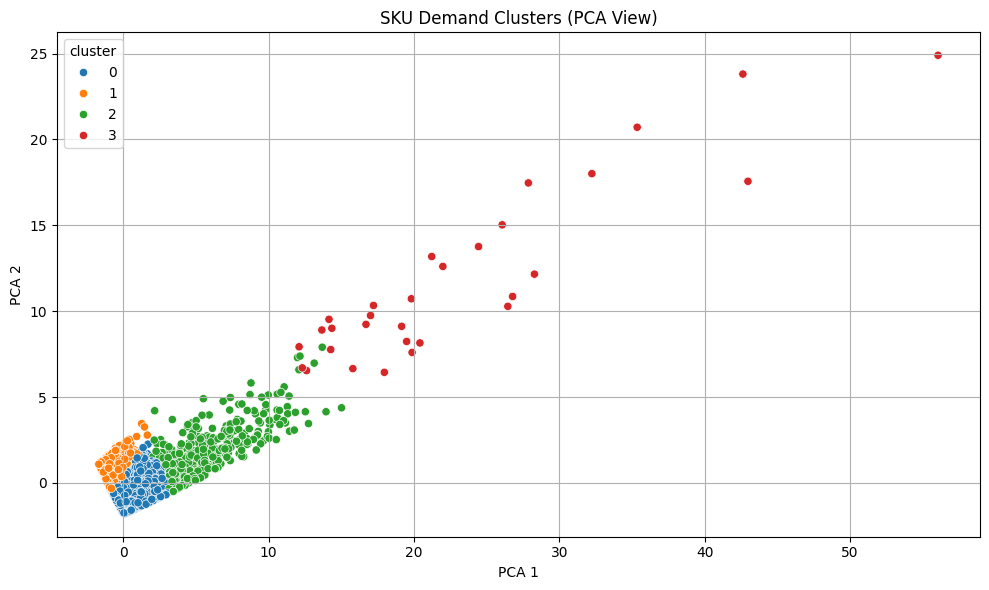

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

#PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
features['PCA1'] = pca_result[:, 0]
features['PCA2'] = pca_result[:, 1]

#Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='PCA1', y='PCA2', hue='cluster', palette='tab10')
plt.title('SKU Demand Clusters (PCA View)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# This step assumes 'clusters' is already defined above (from sku_clusters.csv)
features = features.merge(clusters.set_index('corp_item_cd'), left_index=True, right_index=True)

# Generate profile summary
cluster_profiles = features.groupby('cluster').mean().reset_index()

# Export
cluster_profiles.to_csv("cluster_profiles_summary.csv", index=False)

# Download
from google.colab import files
files.download("cluster_profiles_summary.csv")


In [ ]:
from google.colab import files

# Export to CSV
cluster_output = features[['cluster']].reset_index()
cluster_output.to_csv("sku_clusters.csv", index=False)

# Download
files.download("sku_clusters.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>